In [98]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta
from scipy.interpolate import LinearNDInterpolator
import plotly.express as px
import matplotlib.pyplot as plt

In [149]:
# GOES FROM COLLOCATED MSS TO MONTLY OBSERVATIONS OF MSS ANOMALY GRIDDED TO 1x1
directory = "C:/Users/syversk/Desktop/mss_collocated"
files = os.listdir(directory)
df_list = []
for i in tqdm(range(len(files))):
    df = pd.read_csv(directory + "/" + files[i])
    df = calculate_mss_anomaly_for_each_day_df(df)
    df_list.append(df)
    # New month check
    if (i < len(files) -1) and files[i][0:7] != files[i+1][0:7]:
        df = pd.concat(df_list)
        df = group_dataframe_temporally(df)
        df.to_csv( "C:/Users/syversk/Desktop/mss_collocated_with_anomaly_towards/" + files[i][0:7] + ".csv" ,index=False)
        df_list = []
    if (i == len(files) -1):
        df = pd.concat(df_list)
        df = group_dataframe_temporally(df)
        df.to_csv( "C:/Users/syversk/Desktop/mss_collocated_with_anomaly_towards/" + files[i][0:7] + ".csv" ,index=False)

  0%|                                                                                                                                                        | 0/1681 [00:02<?, ?it/s]
Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000026843C46160>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\Prosjektoppgave\lib\weakref.py", line 371, in remove
    self = selfref()
KeyboardInterrupt: 
Exception ignored in: <function BaseGeometry.__del__ at 0x0000026843CFE8B0>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\Prosjektoppgave\lib\site-packages\shapely\geometry\base.py", line 242, in __del__
    self.empty(val=None)
KeyboardInterrupt: 

KeyboardInterrupt



In [150]:
# GOES FROM MONTLY MSS ANOMALY OBSERVATIONS TO ALL TIME MSS ANOMALY WITH MICROPLASTICS INTERPOLTATED 1x1
directory = "C:/Users/syversk/Desktop/mss_collocated_with_anomaly_towards"
files = os.listdir(directory)
df_list = []
for i in tqdm(range(len(files))):
    df = pd.read_csv(directory + "/" + files[i])
#Go from montly to all average    
    df_list.append(df)
df = pd.concat(df_list)
df = group_dataframe_temporally(df)
df = interp_microplastics(df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.10it/s]


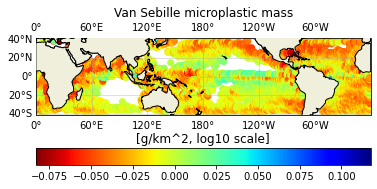

In [159]:
import cartopy.crs as ccrs
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib

# HOW TO CENTRE TO PACIFIC
def plot_var_2(df, var):
    # Settings for the plot
    mycmap = plt.get_cmap('jet').reversed()
    proj = ccrs.PlateCarree(180)
    ax = plt.axes(projection=proj)
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines(draw_labels=True, alpha=0.5)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['lon']+180, df['lat'], c=list(df[var]), cmap=mycmap)
    bar = plt.colorbar(pad=0.15, orientation='horizontal')
    plt.title('Van Sebille microplastic mass')
    '''
    ax.add_patch(matplotlib.patches.Rectangle(xy=[220, -40], width=40, height=20,
                                    alpha=1,
                                    color = 'red',
                                    fill = None,
                                    transform=ccrs.PlateCarree())
                 )
    '''
    bar.ax.set_title('[g/km^2, log10 scale]')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('region.png')
    plt.show()
plot_var_2(df, "mss_anomaly_delta")

In [155]:
df = df[df["mss_anomaly_wind"] < 0]
df = df[df["mss_anomaly_wind"] > -0.05]

In [147]:
def find_highest_corrolation_boundries(df, param = "mss_anomaly_delta"):
    number = np.linspace(-0.2, 0.1, 100).tolist()
    max_corr = 0
    for numb in number:
        for numb2 in number:
            df_reduced = df[df[param] < numb]
            df_reduced = df_reduced[df_reduced[param]> numb2]
            if len(df_reduced) > len(df)*2/3:
                corr = df_reduced.corr()[param][4]
                if abs(corr) > abs(max_corr):
                    max_corr = corr
                    max_int = numb
                    min_int = numb2
    print(max_corr, max_int, min_int)
    df_reduced_optimally = df[df[param] < max_int]
    return df_reduced_optimally[df_reduced_optimally[param] > min_int] 
df = find_highest_corrolation_boundries(df)

-0.156917074504145 0.054545454545454564 -0.12424242424242424


In [156]:
fig = px.density_heatmap(df, y="micro_mass", x="mss_anomaly_wind" , color_continuous_scale=px.colors.sequential.Blackbody)
fig.update_layout(
    xaxis_title= r"$\text{MSS anomaly #3}$",
    yaxis_title= r"$\text{Microplastic mass, (g/km^2, log10 scale)}$",
    legend_title="Legend Title",
    font=dict(size=25,),
)
fig.show()

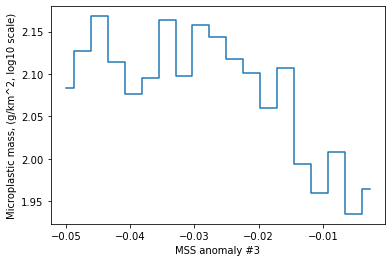

In [158]:
bin_df = pd.DataFrame({'mss':df.mss_anomaly_wind, 'micro' : df.micro_mass })
bin_df['mss_ano'] = pd.cut(bin_df['mss'], bins = np.linspace(bin_df.mss.min(), bin_df.mss.max(), 20)).apply(lambda x: x.left)
bin_df
mean_micro_by_bin = bin_df.groupby(['mss_ano'], as_index=False)['micro'].mean()
mean_micro_by_bin
plt.step(
    mean_micro_by_bin['mss_ano'],
    mean_micro_by_bin['micro'],
    where='mid',
)
plt.xlabel('MSS anomaly #3')
plt.ylabel('Microplastic mass, (g/km^2, log10 scale)')
plt.savefig('mss_ano_3.png')
plt.show()

In [5]:
def init_df(df):
    df = remove_extra(df)
    df.to_csv( "C:/Users/syversk/Desktop/mss_collocated/" + file ,index=False)
    df_cr1 = reduce_area_of_df(df, "cr1")
    df_cr1.to_csv( "C:/Users/syversk/Desktop/cr1/" + file ,index=False)
    df = reduce_area_of_df(df, "cr2")
    df.to_csv( "C:/Users/syversk/Desktop/cr2/" + file ,index=False)
    
def calculate_mss_anomaly_for_each_day_df(df):
    df = df[df['era_wind'] < 11]
    df = df[df['era_wind'] > 3]
    df['mss_anomaly_wind'] = df.apply(lambda row: calculate_mss_anomaly(row.mss, row.era_wind), axis = 1)
    df['mss_anomaly_delta'] = df.apply(lambda row: calculate_mss_anomaly(row.mss, row.delta), axis = 1)
    df = make_data_grided(df)
    df = group_dataframe_temporally(df)
    return df

def reduce_area_of_df(df, cr):
    if cr == "cr1":
        df = df[df.lat <= -10]
        df = df[df.lat >= -25]
        df = df[df.lon >= 105]
        df = df[df.lon <= 120]
    else:
        df = df[df.lat >= 10]
        df = df[df.lat <= 20]
        df = df[df.lon >= 128]
        df = df[df.lon <= 143]
    return df

def remove_extra(df):
    rel_wind_current = np.sqrt((df["era_u10"] - df["oscar_u"])**2 + (df["era_v10"] - df["oscar_v"])**2)
    df.drop(['era_u10', "oscar_u", "era_v10", "oscar_v", "oscar_current"], inplace=True, axis=1)
    df["delta"] = rel_wind_current
    return df

def calculate_mss_anomaly(mss, wind_or_delta, self_trained = False):
    if self_trained:
        c = [0.00370243 , 1.07334119 , 1.33996524 , 5.66160183 , -1.01960507]
    else:
        c = [0.0035, 1, 0.62, 6, -3.39]
    if wind_or_delta <= 3.49:
        mss_mod = c[0]*(c[1]*wind_or_delta + c[2])
    else:
        mss_mod = c[0]*(c[3]*np.log(wind_or_delta) + c[4])
    return (mss-mss_mod)/mss_mod

def grid_data_sub(lat_lon):
    # 0.25 0.25
    #return round(lat_lon*4)/4
    
    return round(lat_lon)

#Average spatially
def make_data_grided(df):
    df["lon"] = df["lon"].apply(lambda lon: grid_data_sub(lon))
    df["lat"] = df["lat"].apply(lambda lat: grid_data_sub(lat))
    return df

def interp_microplastics(df):
    directory = "C:/Users/syversk/Desktop"
    mic_df = pd.read_csv(directory + "/" + "micro_df.csv")
    interp_micro_mass = LinearNDInterpolator(list(zip(mic_df['lon'], mic_df['lat'])), mic_df['vansebillemodel_mass_log'])
    interp_micro_abu = LinearNDInterpolator(list(zip(mic_df['lon'], mic_df['lat'])), mic_df['vansebillemodel_abundance_log'])
    df['micro_mass'] = interp_micro_mass(df['lon'], df['lat'])
    df['abundace'] = interp_micro_abu(df['lon'], df['lat'])
    return df

#Average all temporally
def group_dataframe_temporally(df):
    df = df.groupby(['lon', 'lat'], as_index=False)[['mss_anomaly_delta', 'mss_anomaly_wind']].mean()
    return df

def hours_to_date(d0, hours):
    day = d0 + timedelta(hours=hours)
    return day

#Average temporally to dates
def group_dataframe(df):
    d0 = date(1992, 10, 5)
    df["time"] = df["time"].apply(lambda time: hours_to_date(d0,time))
    df = df.groupby(['lon', 'lat', "time"], as_index=False)[['mss_anomaly_delta', 'mss_anomaly_wind']].mean()
    df = df.rename(columns={"time": "date"})
    return df

def reduce_based_on_sd(df):
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]